In [1]:
import re
import umap
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
tqdm.pandas()

In [ ]:
data_path = "./data/jigsaw-toxic-severity-rating/"
validation_data = pd.read_csv(data_path+"validation_data.csv")
data = pd.read_csv(data_path+"comments_to_score.csv")

In [ ]:
validation_data.head()

In [ ]:
worker_freq_dict = dict(validation_data.worker.value_counts())
workers = sorted(list(worker_freq_dict.keys()))
worked = [worker_freq_dict[w] for w in workers]

### Plotting worker productivity

In [ ]:
plt.bar(workers, worked, align='center', color='green')
# plt.xticks(workers, worked)
plt.title("Work distribution")
plt.xlabel("Worker ID")
plt.ylabel("Data points annotated")
plt.show()

In [ ]:
fig, ax = plt.subplots()
validation_data.worker.value_counts().plot(ax=ax, kind='hist', color='green')
plt.show()

### Plotting length of each comment against type of comment

In [ ]:
less_toxic_lens = validation_data.less_toxic.apply(lambda x: len(x.split()))
more_toxic_lens = validation_data.more_toxic.apply(lambda x: len(x.split()))

In [ ]:
fig = plt.figure(figsize =(10, 6))
 
ax = fig.add_axes([0, 0, 1, 1])

bp = ax.boxplot([less_toxic_lens, more_toxic_lens])

ax.set_xticklabels(['less toxic', 'more toxic'])

plt.title("Comment lengths box plot")

plt.show()


## Plotting few vectors in 2D

Here we look at various embedding approaches and use UMAP to project them to 2D space and plot

### Tf-idf plots

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
corpus = np.concatenate([validation_data.less_toxic.apply(lambda x: x.replace("\n", "")).values, 
                         validation_data.more_toxic.apply(lambda x: x.replace("\n", "")).values])
tfidf_vecs = vectorizer.fit(corpus)

In [ ]:
sampled_df = validation_data.sample(5000)

In [ ]:
sampled_corpus_less = sampled_df.less_toxic.apply(lambda x: x.replace("\n", "")).values

sampled_corpus_more = sampled_df.more_toxic.apply(lambda x: x.replace("\n", "")).values

In [ ]:
sampled_corpus.shape

In [ ]:
tfidf_vecs_less = vectorizer.transform(sampled_corpus_less).toarray()
tfidf_vecs_more = vectorizer.transform(sampled_corpus_more).toarray()

In [ ]:
embedding = umap.UMAP(n_components=2,
                      n_neighbors=15,
                      min_dist=0.3,
                      metric='correlation').fit_transform(np.concatenate([tfidf_vecs_less, tfidf_vecs_more]))

In [ ]:
x_less = embedding[:5000,0]
y_less = embedding[:5000,1]
x_more = embedding[5000:,0]
y_more = embedding[5000:,1]

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x_less, y_less, color='green', alpha=0.5, label='less toxic')
ax1.scatter(x_more, y_more, color='red', alpha=0.5, label='more toxic')
plt.legend(loc='lower right')
plt.show()

We can see that both overlap quite a bit. We might need to move over to better embeddings

### BERT plots

In [27]:
import torch
from transformers import BertTokenizer, BertModel

In [28]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [29]:
def get_bert_embedding(text):
    
    marked_text = "[CLS] " + text + " [SEP]"

    # Split the sentence into tokens.
    tokenized_text = tokenizer.tokenize(marked_text)
    
    # Truncating to 512 tokens
    tokenized_text = tokenized_text[:512]

    # Map the token strings to their vocabulary indeces.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    with torch.no_grad():

        outputs = model(tokens_tensor, segments_tensors)

        # Evaluating the model will return a different number of objects based on 
        # how it's  configured in the `from_pretrained` call earlier. In this case, 
        # becase we set `output_hidden_states = True`, the third item will be the 
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]
        
#     token_embeddings = torch.stack(hidden_states, dim=0)
#     token_embeddings = torch.squeeze(token_embeddings, dim=1)
#     token_embeddings = token_embeddings.permute(1,0,2)
    token_vecs = hidden_states[-2][0]
    sentence_embedding = torch.mean(token_vecs, dim=0)
    
    return sentence_embedding.cpu().detach().numpy()
                    

In [30]:
def clean(text):
    text = text.replace("\n", "")
    text = " ".join(text.split())
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[0-9]', '', text)
    return text
    

In [ ]:
sampled_df = validation_data.sample(500)

In [ ]:
sampled_df['less_toxic_cleaned'] = sampled_df['less_toxic'].progress_apply(clean)
sampled_df['more_toxic_cleaned'] = sampled_df['more_toxic'].progress_apply(clean)

In [ ]:
sampled_df['less_toxic_vecs'] = sampled_df['less_toxic_cleaned'].progress_apply(get_bert_embedding)
sampled_df['more_toxic_vecs'] = sampled_df['more_toxic_cleaned'].progress_apply(get_bert_embedding)

In [ ]:
len(list(sampled_df.less_toxic_vecs))

In [ ]:
embedding = umap.UMAP(n_components=2,
                      n_neighbors=15,
                      min_dist=0.3,
                      metric='correlation').fit_transform(np.concatenate([list(sampled_df.less_toxic_vecs), 
                                                                          list(sampled_df.more_toxic_vecs)]))


In [ ]:
x_less = embedding[:500,0]
y_less = embedding[:500,1]
x_more = embedding[500:,0]
y_more = embedding[500:,1]

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x_less, y_less, color='cyan', alpha=0.5, label='less toxic')
ax1.scatter(x_more, y_more, color='pink', alpha=0.5, label='more toxic')
plt.legend(loc='lower right')
plt.show()

Too much overlap of BERT vectors as well. Seems unlikely that a classifier can do much

## Loading data from classification challenge

In [2]:
toxic_classification_test = pd.read_csv("./data/jigsaw-toxic-comment-classification-challenge/test.csv")
toxic_classification_test_labels = pd.read_csv("./data/jigsaw-toxic-comment-classification-challenge/test_labels.csv")
toxic_classification_train = pd.read_csv("./data/jigsaw-toxic-comment-classification-challenge/train.csv")

In [4]:
toxic_classification_test_labels.head(1)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1


In [6]:
df_test = pd.merge(toxic_classification_test, toxic_classification_test_labels, how='left', on='id')
df = pd.concat([toxic_classification_train, df_test])

df['toxicity'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)

In [17]:
df.threat.value_counts()

0    222860
1       689
Name: threat, dtype: int64

### Removing -1 labels

In [18]:
df = df[(df['toxic']!=-1) & (df['severe_toxic']!=-1) & (df['obscene']!=-1) & (df['threat']!=-1) & (df['insult']!=-1) & (df['identity_hate']!=-1)]

In [19]:
df.shape

(223549, 9)

### We add all label values to get idea of degree of severity

In [20]:
df['toxicity'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)

## Visualizing the comments in 2D

In [47]:
sampled_df = df.groupby('toxicity', group_keys=False).apply(lambda x: x.sample(min(len(x), 200)))
bert_vecs = sampled_df.comment_text.apply(clean).progress_apply(get_bert_embedding)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1245/1245 [06:51<00:00,  3.02it/s]


In [51]:
sampled_df.toxicity.value_counts()

5    200
4    200
3    200
2    200
1    200
0    200
6     45
Name: toxicity, dtype: int64

In [59]:
embedding = umap.UMAP(n_components=2,
                      n_neighbors=15,
                      min_dist=0.1,
                      metric='euclidean').fit_transform(list(bert_vecs))

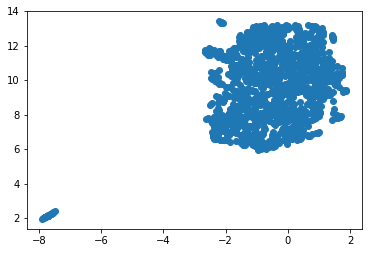

In [60]:
x = embedding[:,0]
y = embedding[:,1]
plt.scatter(x, y)
plt.show()

## Classifier fitting

Idea is to fit a classifier to predict from 0 to 5, then use the predicted labels along with probability to rank

In [31]:
df.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
